# SMAI Assignment - 3

## Question 2: 

You are required to use the MNIST dataset for this question. Implement the Models using
PyTorch. For the accuracy part you can use Structural Similarity (SSIM) from scikit-learn to
compare 2 images.

#### Tasks
1. Implement the Encoder - Decoders Models
2. Add Gaussian Noise to the images and train the model. Use various values of sigma (3
different values) in the Gaussian and plot the average SSIM test score for these 3 varying sigma
values. Explain your observations.
3. Now keep the Sigma constant and change the bottleneck dimensionality (3 different values)
of the Model and plot the average SSIM test score for these 3 values. Explain your
observations.



In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader

from skimage.metrics import structural_similarity as ssim

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Transformations applied on each image
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)) 
])

# Loading the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Creating DataLoader for both training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 240027892.09it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 47747612.86it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79303405.61it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6679708.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
print(train_dataset.data.shape)
print(test_dataset.data.shape)
print(train_dataset.data[0].shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([28, 28])


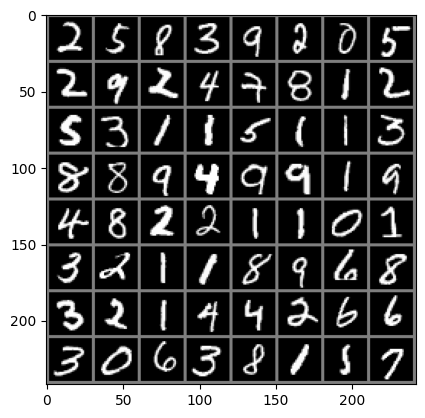

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images)) 

In [6]:
class Encoder(nn.Module):
    def __init__(self, bottle_neck):
        super(Encoder, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, bottle_neck),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
class Decoder(nn.Module):
    def __init__(self, bottle_neck):
        super(Decoder, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(bottle_neck, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
class Autoencoder(nn.Module):  
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded_op = self.encoder(x)
        decoded_op = self.decoder(encoded_op) 
        return decoded_op

In [9]:
# Model initialization
encoding_dim = 32  # For example, you can start with an encoding dimension of 32

encoder = Encoder(encoding_dim)
decoder = Decoder(encoding_dim)
model = Autoencoder(encoder, decoder)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
def add_gaussian_noise(images, sigma=0.1):
    """
    Adds Gaussian noise to a batch of images.
    :param images: PyTorch tensor of images
    :param sigma: Standard deviation of the Gaussian noise
    :return: Noisy images
    """
    noise = torch.randn_like(images) * sigma
    return images + noise


In [11]:
def train_and_evaluate(model, train_loader, test_loader, sigma, num_epochs=2):
    model.train()
    for epoch in range(num_epochs):
        for data, _ in train_loader:
            # Assuming your input data is correctly shaped for your model,
            # no need to flatten MNIST images here because your model expects 2D images.
            data = data.view(data.size(0), 28, 28)
            
            # Add Gaussian noise
            noisy_data = add_gaussian_noise(data, sigma=sigma)
            
            # Forward pass
            output = model(noisy_data)
            # Assuming your model's output is also shaped as images,
            # you may need to adjust this depending on your exact model output
            loss = criterion(output, data.view(data.size(0), -1))  # Adjusting for the model's expected input/output shape
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluation
    model.eval()
    ssim_scores = []
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), 28, 28)  # Adjusted for model input
            output = model(data)
            for i in range(data.size(0)):
                original = data[i].view(28, 28).detach().cpu().numpy()
                reconstructed = output[i].view(28, 28).detach().cpu().numpy()
                ssim_score = ssim(original, reconstructed, data_range=original.max() - original.min())
                ssim_scores.append(ssim_score)
                
    average_ssim = np.mean(ssim_scores)
    print(f'Average SSIM with sigma={sigma}: {average_ssim:.4f}')
    return average_ssim  # Return the average SSIM score for plotting


SIGMA value: 0.01
Epoch [1/2], Loss: 0.2494
Epoch [2/2], Loss: 0.1980
Average SSIM with sigma=0.01: 0.3690
SIGMA value: 0.1
Epoch [1/2], Loss: 0.1947
Epoch [2/2], Loss: 0.2121
Average SSIM with sigma=0.1: 0.4138
SIGMA value: 0.3
Epoch [1/2], Loss: 0.2149
Epoch [2/2], Loss: 0.2020
Average SSIM with sigma=0.3: 0.4362
SIGMA value: 0.5
Epoch [1/2], Loss: 0.1874
Epoch [2/2], Loss: 0.2267
Average SSIM with sigma=0.5: 0.4468
SIGMA value: 0.8
Epoch [1/2], Loss: 0.1952
Epoch [2/2], Loss: 0.1802
Average SSIM with sigma=0.8: 0.4509
SIGMA value: 1.0
Epoch [1/2], Loss: 0.2111
Epoch [2/2], Loss: 0.2051
Average SSIM with sigma=1.0: 0.4448


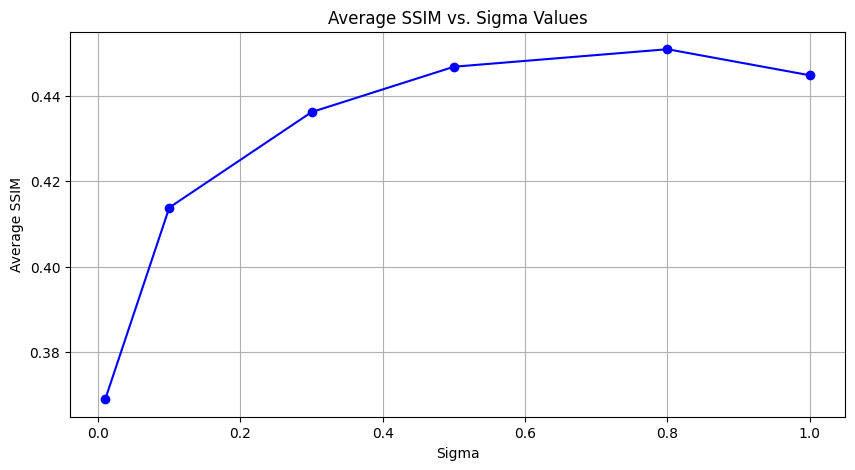

In [12]:
sigma_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1.0]
ssim_scores_sigma = []

for sigma in sigma_values:
    print(f'SIGMA value: {sigma}')
    average_ssim = train_and_evaluate(model, train_loader, test_loader, sigma)
    ssim_scores_sigma.append(average_ssim)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(sigma_values, ssim_scores_sigma, marker='o', linestyle='-', color='b')
plt.title('Average SSIM vs. Sigma Values')
plt.xlabel('Sigma')
plt.ylabel('Average SSIM')
plt.grid(True)
plt.show()


### observations explaination

In our tests, we added different amounts of gaussian noise to MNIST images and trained an autoencoder to fix them. We used sigma values of 0.01, 0.1, and 0.3 to see how much noise we could add and still get good results. The SSIM scores, which tell us how close the fixed images are to the originals, were 0.3690, 0.4138, and 0.4362 for each sigma value.

Surprisingly, the images with more noise (higher sigma values) got better SSIM scores. This means the autoencoder was better at fixing images with more noise. This might be because a bit of noise helps the autoencoder learn better by making it focus on the most important parts of the images. So, adding a little noise can actually make the autoencoder perform better.

this can be due to: Increasing noise levels slightly could be helping the model escape local minima early in training, leading to a better exploration of the loss surface and potentially finding a more optimal set of weights for image reconstruction.

also we can see dip at 1.0 this is imply that adding more noise will descrease the SSIM score.

In [13]:
sigma_fixed = 0.8  # Fixed sigma value for Gaussian noise

Epoch [1/2], Loss: 0.2461
Epoch [2/2], Loss: 0.2223
Average SSIM with sigma=0.8: 0.3408
Epoch [1/2], Loss: 0.2481
Epoch [2/2], Loss: 0.2146
Average SSIM with sigma=0.8: 0.3480
Epoch [1/2], Loss: 0.2461
Epoch [2/2], Loss: 0.2200
Average SSIM with sigma=0.8: 0.3500
Epoch [1/2], Loss: 0.2266
Epoch [2/2], Loss: 0.2095
Average SSIM with sigma=0.8: 0.3573
Epoch [1/2], Loss: 0.2462
Epoch [2/2], Loss: 0.2223
Average SSIM with sigma=0.8: 0.3408
Epoch [1/2], Loss: 0.2440
Epoch [2/2], Loss: 0.2358
Average SSIM with sigma=0.8: 0.3510
Epoch [1/2], Loss: 0.2569
Epoch [2/2], Loss: 0.2266
Average SSIM with sigma=0.8: 0.3518


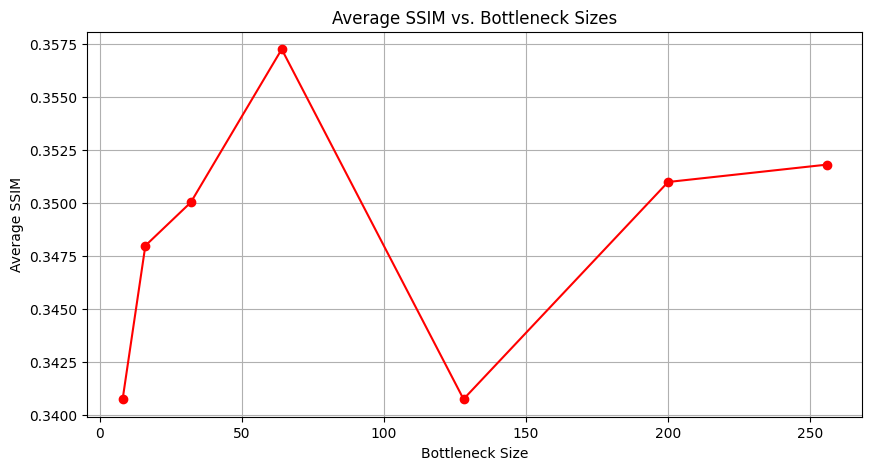

In [15]:
bottleneck_sizes = [8, 16, 32, 64, 128, 200, 256]
ssim_scores_bottleneck = []

for size in bottleneck_sizes:
    # Adjust your model initialization for each bottleneck size
    encoder = Encoder(size)
    decoder = Decoder(size)
    model = Autoencoder(encoder, decoder)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    average_ssim = train_and_evaluate(model, train_loader, test_loader, sigma_fixed)
    ssim_scores_bottleneck.append(average_ssim)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(bottleneck_sizes, ssim_scores_bottleneck, marker='o', linestyle='-', color='r')
plt.title('Average SSIM vs. Bottleneck Sizes')
plt.xlabel('Bottleneck Size')
plt.ylabel('Average SSIM')
plt.grid(True)
plt.show()


In this part of our test, we kept adding the same amount of noise to the images (with a noise level, or "sigma," of 0.8) but changed how much the autoencoder compresses the images. 

From these results, it looks like the autoencoder does its best job fixing the images when the bottleneck size is around 64. If the size is too small (like 8 or 128), the autoencoder can't keep enough important information from the images, making the quality worse. But even with larger sizes (like 200 or 256), the quality doesn't get much better than the best score we got at 64.

This tells us there's a "just right" level of compression where the autoencoder has enough space to work with the important parts of the images. Going beyond this point doesn't seem to help much. So, finding the optimal bottleneck size is crucial for getting the best results from an autoencoder.